In [1]:
import ee
ee.Authenticate()

ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Hs63VAu5l__N9u6MhCHTM7W_4YHz8iCmm3HLPuxE508&tc=gkOYGRu-3f9tOo_L7225PWAEZGWhXKnu6knYnVjvCeY&cc=_dXPFS7utNA6MsQnGEIEZVYyvscTzx3ssTjPExQnNdw

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh5OFz5frzcdSIGiYAOUIVPxiOQ_9RojkXSVW05pwT1oxJLhpQq_Vzg

Successfully saved authorization token.


In [ ]:
#Punto de Teheran del departamento 4 de agua
aoi = ee.Geometry.Point([51.433208,35.695795 ]).buffer(40).bounds()

In [ ]:
aoi = ee.Geometry.Polygon(aoi.getInfo()['coordinates'])

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [3]:
def chi2cdf(chi2, df):
    """Calculates Chi square cumulative distribution function for
       df degrees of freedom using the built-in incomplete gamma
       function gammainc().
    """
    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

def det(im):
    """Calculates determinant of 2x2 diagonal covariance matrix."""
    return im.expression('b(0)*b(1)')

In [4]:
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds Earth Engine layers to a folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [8]:
#Leer los puntos desde una url de earth engine
points = input("Ingrese la dirección de los puntos:")


Ingrese la dirección de los puntos:projects/lofty-optics-360613/assets/PuntoAnual


In [9]:
table = ee.FeatureCollection(points)

In [89]:
id = 'C69yB84'

In [94]:
def func_qom (feature):
  ft =  feature.set('Date', ee.Date(feature.get('Date'))) \
                .set('ids', feature.get('ids'))
  return ee.Feature(ft)

In [95]:
placemarks = table.select(['Date', 'ids']).map(func_qom).filter(ee.Filter.eq('ids',id))

In [96]:
def get_snip(feature):
  return ee.Feature(feature.buffer(40).bounds())

In [97]:
snips = placemarks.map(get_snip)

In [98]:
aoi = ee.Geometry.Polygon(snips.getInfo()['features'][0]['geometry']['coordinates'])

In [99]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
           .filterBounds(aoi)
           .filterDate(ee.Date('2020-11-15'),ee.Date('2021-04-30'))
           .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
           .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
           .sort('date'))

timestamplist = (im_coll.aggregate_array('date')
                 .map(lambda d: ee.String('T').cat(ee.String(d)))
                 .getInfo())
timestamplist

['T20201120',
 'T20201202',
 'T20201208',
 'T20201214',
 'T20201220',
 'T20201226',
 'T20210101',
 'T20210107',
 'T20210113',
 'T20210119',
 'T20210125',
 'T20210131',
 'T20210206',
 'T20210212',
 'T20210218',
 'T20210224',
 'T20210314',
 'T20210320',
 'T20210326',
 'T20210401',
 'T20210407',
 'T20210413',
 'T20210419',
 'T20210425']

In [100]:
def clip_img(img):
    """Clips a list of images."""
    return ee.Image(img).clip(aoi)

im_list = im_coll.toList(im_coll.size())
im_list = ee.List(im_list.map(clip_img))

im_list.length().getInfo()

24

In [101]:
def selectvv(current):
    return ee.Image(current).select('VV')


# Layer 1
vv_list = im_list.map(selectvv)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=25)
rgb_images = (ee.Image.rgb(vv_list.get(0), vv_list.get(1), vv_list.get(2))
              .log10().multiply(10))
mp.add_ee_layer(rgb_images, {'min': -20,'max': 0}, 'rgb composite')
mp.add_child(folium.LayerControl())

In [102]:
def omnibus(im_list, m = 4.7):
    """Calculates the omnibus test statistic, monovariate case."""
    def log(current):
        return ee.Image(current).log()

    im_list = ee.List(im_list)
    k = im_list.length()
    klogk = k.multiply(k.log())
    klogk = ee.Image.constant(klogk)
    sumlogs = ee.ImageCollection(im_list.map(log)).reduce(ee.Reducer.sum())
    logsum = ee.ImageCollection(im_list).reduce(ee.Reducer.sum()).log()
    return klogk.add(sumlogs).subtract(logsum.multiply(k)).multiply(-2*m)

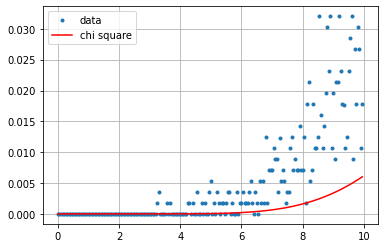

In [103]:
k = im_list.length().getInfo()
hist = (omnibus(vv_list.slice(0,k))
        .reduceRegion(ee.Reducer.fixedHistogram(0, 10, 200), geometry=aoi, scale=1)
        .get('constant')
        .getInfo())

a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, k-1), '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

In [104]:
#k cantidad de imagenes que se toman para analizar los cambios
# Layer 2
k = im_list.length().getInfo(); alpha = 0.01
p_value = ee.Image.constant(1).subtract(chi2cdf(omnibus(vv_list), k-1))
c_map = p_value.multiply(0).where(p_value.lt(alpha), 1)
# Make the no-change pixels transparent.
c_map = c_map.updateMask(c_map.gt(0))
# Overlay onto the folium map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=25)
mp.add_ee_layer(c_map, {'min': 0,'max': 1, 'palette': ['black', 'red']}, 'change map')
mp.add_child(folium.LayerControl())

In [105]:
def sample_vv_imgs(j):
    """Samples the test statistics Rj in the region aoi_sub."""
    j = ee.Number(j)
    # Get the factors in the expression for Rj.
    sj = vv_list.get(j.subtract(1))
    jfact = j.pow(j).divide(j.subtract(1).pow(j.subtract(1)))
    sumj = ee.ImageCollection(vv_list.slice(0, j)).reduce(ee.Reducer.sum())
    sumjm1 = ee.ImageCollection(vv_list.slice(0, j.subtract(1))).reduce(ee.Reducer.sum())
    # Put them together.
    Rj = sumjm1.pow(j.subtract(1)).multiply(sj).multiply(jfact).divide(sumj.pow(j)).pow(5)
    # Sample Rj.
    sample = (Rj.sample(region=aoi, scale=10, numPixels=1000, seed=123)
              .aggregate_array('VV_sum'))
    return sample

# Sample the first few list indices.
samples = ee.List.sequence(2, 8).map(sample_vv_imgs)

# Calculate and display the correlation matrix.
np.set_printoptions(precision=2, suppress=True)
print(np.corrcoef(samples.getInfo()))

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2453: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = np.asarray(m)


TypeError: ignored

In [106]:
def log_det_sum(im_list, j):
    """Returns log of determinant of the sum of the first j images in im_list."""
    im_ist = ee.List(im_list)
    sumj = ee.ImageCollection(im_list.slice(0, j)).reduce(ee.Reducer.sum())
    return ee.Image(det(sumj)).log()

def log_det(im_list, j):
    """Returns log of the determinant of the jth image in im_list."""
    im = ee.Image(ee.List(im_list).get(j.subtract(1)))
    return ee.Image(det(im)).log()

def pval(im_list, j, m=4.4):
    """Calculates -2logRj for im_list and returns P value and -2logRj."""
    im_list = ee.List(im_list)
    j = ee.Number(j)
    m2logRj = (log_det_sum(im_list, j.subtract(1))
               .multiply(j.subtract(1))
               .add(log_det(im_list, j))
               .add(ee.Number(2).multiply(j).multiply(j.log()))
               .subtract(ee.Number(2).multiply(j.subtract(1))
               .multiply(j.subtract(1).log()))
               .subtract(log_det_sum(im_list,j).multiply(j))
               .multiply(-2).multiply(m))
    pv = ee.Image.constant(1).subtract(chi2cdf(m2logRj, 2))
    return (pv, m2logRj)

def p_values(im_list):
    """Pre-calculates the P-value array for a list of images."""
    im_list = ee.List(im_list)
    k = im_list.length()

    def ells_map(ell):
        """Arranges calculation of pval for combinations of k and j."""
        ell = ee.Number(ell)
        # Slice the series from k-l+1 to k (image indices start from 0).
        im_list_ell = im_list.slice(k.subtract(ell), k)

        def js_map(j):
            """Applies pval calculation for combinations of k and j."""
            j = ee.Number(j)
            pv1, m2logRj1 = pval(im_list_ell, j)
            return ee.Feature(None, {'pv': pv1, 'm2logRj': m2logRj1})

        # Map over j=2,3,...,l.
        js = ee.List.sequence(2, ell)
        pv_m2logRj = ee.FeatureCollection(js.map(js_map))

        # Calculate m2logQl from collection of m2logRj images.
        m2logQl = ee.ImageCollection(pv_m2logRj.aggregate_array('m2logRj')).sum()
        pvQl = ee.Image.constant(1).subtract(chi2cdf(m2logQl, ell.subtract(1).multiply(2)))
        pvs = ee.List(pv_m2logRj.aggregate_array('pv')).add(pvQl)
        return pvs

    # Map over l = k to 2.
    ells = ee.List.sequence(k, 2, -1)
    pv_arr = ells.map(ells_map)

    # Return the P value array ell = k,...,2, j = 2,...,l.
    return pv_arr

In [107]:
def filter_j(current, prev):
    """Calculates change maps; iterates over j indices of pv_arr."""
    pv = ee.Image(current)
    prev = ee.Dictionary(prev)
    pvQ = ee.Image(prev.get('pvQ'))
    i = ee.Number(prev.get('i'))
    cmap = ee.Image(prev.get('cmap'))
    smap = ee.Image(prev.get('smap'))
    fmap = ee.Image(prev.get('fmap'))
    bmap = ee.Image(prev.get('bmap'))
    alpha = ee.Image(prev.get('alpha'))
    j = ee.Number(prev.get('j'))
    cmapj = cmap.multiply(0).add(i.add(j).subtract(1))
    # Check      Rj?            Ql?                  Row i?
    tst = pv.lt(alpha).And(pvQ.lt(alpha)).And(cmap.eq(i.subtract(1)))
    # Then update cmap...
    cmap = cmap.where(tst, cmapj)
    # ...and fmap...
    fmap = fmap.where(tst, fmap.add(1))
    # ...and smap only if in first row.
    smap = ee.Algorithms.If(i.eq(1), smap.where(tst, cmapj), smap)
    # Create bmap band and add it to bmap image.
    idx = i.add(j).subtract(2)
    tmp = bmap.select(idx)
    bname = bmap.bandNames().get(idx)
    tmp = tmp.where(tst, 1)
    tmp = tmp.rename([bname])
    bmap = bmap.addBands(tmp, [bname], True)
    return ee.Dictionary({'i': i, 'j': j.add(1), 'alpha': alpha, 'pvQ': pvQ,
                          'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap':bmap})

def filter_i(current, prev):
    """Arranges calculation of change maps; iterates over row-indices of pv_arr."""
    current = ee.List(current)
    pvs = current.slice(0, -1 )
    pvQ = ee.Image(current.get(-1))
    prev = ee.Dictionary(prev)
    i = ee.Number(prev.get('i'))
    alpha = ee.Image(prev.get('alpha'))
    median = prev.get('median')
    # Filter Ql p value if desired.
    pvQ = ee.Algorithms.If(median, pvQ.focalMedian(2.5), pvQ)
    cmap = prev.get('cmap')
    smap = prev.get('smap')
    fmap = prev.get('fmap')
    bmap = prev.get('bmap')
    first = ee.Dictionary({'i': i, 'j': 1, 'alpha': alpha ,'pvQ': pvQ,
                           'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap': bmap})
    result = ee.Dictionary(ee.List(pvs).iterate(filter_j, first))
    return ee.Dictionary({'i': i.add(1), 'alpha': alpha, 'median': median,
                          'cmap': result.get('cmap'), 'smap': result.get('smap'),
                          'fmap': result.get('fmap'), 'bmap': result.get('bmap')})

In [108]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0, k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    return ee.Dictionary(pv_arr.iterate(filter_i, first))

cmap: the interval of the most recent change
smap: the interval of the first change
bmap: the changes in each interval

In [109]:


# Layer 3
result = change_maps(im_list, median=True, alpha=0.01)

# Extract the change maps and display.
cmap = ee.Image(result.get('cmap'))
smap = ee.Image(result.get('smap'))
fmap = ee.Image(result.get('fmap'))
location = aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'blue', 'cyan', 'yellow', 'red']
mp = folium.Map(location=location, zoom_start=25)
mp.add_ee_layer(cmap, {'min': 0, 'max': 25, 'palette': palette}, 'cmap')
mp.add_ee_layer(smap, {'min': 0, 'max': 25, 'palette': palette}, 'smap')
mp.add_ee_layer(fmap, {'min': 0, 'max': 25, 'palette': palette}, 'fmap')
mp.add_child(folium.LayerControl())

In [110]:
def dmap_iter(current, prev):
    """Reclassifies values in directional change maps."""
    prev = ee.Dictionary(prev)
    j = ee.Number(prev.get('j'))
    image = ee.Image(current)
    avimg = ee.Image(prev.get('avimg'))
    diff = image.subtract(avimg)
    # Get positive/negative definiteness.
    posd = ee.Image(diff.select(0).gt(0).And(det(diff).gt(0)))
    negd = ee.Image(diff.select(0).lt(0).And(det(diff).gt(0)))
    bmap = ee.Image(prev.get('bmap'))
    bmapj = bmap.select(j)
    dmap = ee.Image.constant(ee.List.sequence(1, 3))
    bmapj = bmapj.where(bmapj, dmap.select(2))
    bmapj = bmapj.where(bmapj.And(posd), dmap.select(0))
    bmapj = bmapj.where(bmapj.And(negd), dmap.select(1))
    bmap = bmap.addBands(bmapj, overwrite=True)
    # Update avimg with provisional means.
    i = ee.Image(prev.get('i')).add(1)
    avimg = avimg.add(image.subtract(avimg).divide(i))
    # Reset avimg to current image and set i=1 if change occurred.
    avimg = avimg.where(bmapj, image)
    i = i.where(bmapj, 1)
    return ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j.add(1), 'i': i})

We only have to modify the change_maps function to include the change direction in the bmap image:

In [111]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0,k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    result = ee.Dictionary(pv_arr.iterate(filter_i, first))
    # Post-process bmap for change direction.
    bmap =  ee.Image(result.get('bmap'))
    avimg = ee.Image(im_list.get(0))
    j = ee.Number(0)
    i = ee.Image.constant(1)
    first = ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j, 'i': i})
    dmap = ee.Dictionary(im_list.slice(1).iterate(dmap_iter, first)).get('bmap')
    return ee.Dictionary(result.set('bmap', dmap))

In [112]:
# Run the algorithm with median filter and at 1% significance.
# layer 4
result = ee.Dictionary(change_maps(im_list, median=True, alpha=0.01))
# Extract the change maps and export to assets.
cmap = ee.Image(result.get('cmap'))
smap = ee.Image(result.get('smap'))
fmap = ee.Image(result.get('fmap'))
bmap = ee.Image(result.get('bmap'))
cmaps = ee.Image.cat(cmap, smap, fmap, bmap).rename(['cmap', 'smap', 'fmap']+timestamplist[1:])



# EDIT THE ASSET PATH TO POINT TO YOUR ACCOUNT.
assetId = 'projects/lofty-optics-360613/assets/cmap'+id
#Para extraer al drive
#assexport = ee.batch.Export.image.toDrive(cmaps.toFloat(),
#                                          folder='DetectingChanges',
#                                          region = aoi,
#                                          fileNamePrefix =id,
#                                          scale=1,maxPixels=1e9)

assexport = ee.batch.Export.image.toAsset(cmaps,
                                          description='assetExportTask',
                                          assetId=assetId, scale=1,maxPixels=1e9)

# UNCOMMENT THIS TO EXPORT THE MAP TO YOUR ACCOUNT.
assexport.start()

1 for positive definite differences,
2 for negative definite differences,
3 for indefinite differences.

In [113]:
#cmaps = ee.Image('projects/lofty-optics-360613/assets/cmapDept_4_Teheran')
#cmaps = ee.Image('projects/earthengine-community/tutorials/detecting-changes-in-sentinel-1-imagery-pt-3/cmaps')

# Layer  4
cmaps = cmaps.updateMask(cmaps.gt(0))
location = aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'red', 'cyan', 'yellow']
mp = folium.Map(location=location, zoom_start=20)

lista = cmaps.getInfo()['bands'][3:]
for each in timestamplist:
  if(list(filter(lambda ids: ids['id'] == each, lista))):
    mp.add_ee_layer(cmaps.select(each), {'min': 0,'max': 3, 'palette': palette}, each)

mp.add_child(folium.LayerControl())